# Exploratory Data Analysis

In this section, we add descriptors features to the dataset using the rdkit and perform some exploratory data analysis

Import the needed library for calculating descriptors:

In [163]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

# import the dataset from previous notebook:
df = pd.read_csv('bioactivity_data.csv')

## Lipinski Descriptors

Lipinski descriptors, also known as Lipinski's Rule of Five, are a set of empirical rules to evaluate the 
druglikeness of a compound base on Absorption, Distribution, Metabolism and Excretion. They predict whether a chemical compound with a certain pharmacological or biological activity has properties that would make it a likely orally active drug in humans. These rules are:

No more than 5 hydrogen bond donors (the sum of OHs and NHs).
No more than 10 hydrogen bond acceptors (the sum of Os and Ns).
A molecular weight less than 500 daltons.
A partition coefficient (LogP) not greater than 5.


## Calculate lipinski descriptors

In [164]:
def calculate_lipinski(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_weight = Descriptors.MolWt(mol)
    log_p = Descriptors.MolLogP(mol)
    num_h_donors = Descriptors.NumHDonors(mol)
    num_h_acceptors = Descriptors.NumHAcceptors(mol)
    return mol_weight, log_p, num_h_donors, num_h_acceptors

Add those lpinski descriptors as new features into the dataset

In [165]:
df[['mol_weight','log_p','num_h_donors','num_h_acceptors']] = df['canonical_smiles'].apply(lambda x: pd.Series(calculate_lipinski(x)))
df.head(10)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_level,mol_weight,log_p,num_h_donors,num_h_acceptors
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,intermediate,311.422,3.3188,1.0,2.0
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,intermediate,299.461,3.2412,1.0,3.0
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,intermediate,311.422,3.3188,1.0,2.0
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,inactive,327.877,3.8331,1.0,2.0
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,inactive,372.328,3.9422,1.0,2.0
5,CHEMBL563,CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1,305000.0,inactive,244.265,3.6808,1.0,1.0
6,CHEMBL196279,CC(C(=O)O)c1ccc(-c2ccc(Cl)c(Cl)c2)c(F)c1,75000.0,inactive,313.155,4.9876,1.0,1.0
7,CHEMBL195970,CC(C(=O)O)c1ccc(-c2cc(Cl)cc(Cl)c2)c(F)c1,77000.0,inactive,313.155,4.9876,1.0,1.0
8,CHEMBL195970,CC(C(=O)O)c1ccc(-c2cc(Cl)cc(Cl)c2)c(F)c1,94000.0,inactive,313.155,4.9876,1.0,1.0
9,CHEMBL264006,CC(C(=O)O)c1ccc(-c2ccc(C3CCCCC3)cc2)c(F)c1,21000.0,inactive,326.411,5.7285,1.0,1.0


## Calculate pIC50 values

Convert the standard value of IC50 from nM to M by multiplying 10**-9
pIC50 = -log(IC50)

Add the new column into the dataframe

In [166]:
df['pIC50'] = -np.log10(df['standard_value']*(10**-9))
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_level,mol_weight,log_p,num_h_donors,num_h_acceptors,pIC50
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,intermediate,311.422,3.3188,1.0,2.0,5.301030
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,intermediate,299.461,3.2412,1.0,3.0,5.568636
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,intermediate,311.422,3.3188,1.0,2.0,5.744727
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,inactive,327.877,3.8331,1.0,2.0,4.958607
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,inactive,372.328,3.9422,1.0,2.0,5.000000


## Calculate Molecule descriptors from PaDEL

PaDEL descriptors capture a wide range of molecular properties and characteristics, including physicochemical properties, topological indices, and geometric descriptors.

First we need a smi file in order to run to PaDEL descriptors.

In [167]:
df1 = df[['canonical_smiles', 'molecule_chembl_id']]
df1.to_csv('input.smi', sep = '\t', index = False, header = False)

We can utilize subprocess to run the PaDEL-Descriptor.jar to obtain the results

In [168]:
def calculate_padel_descriptors(input_file, output_file, padel_jar='PaDEL-Descriptor/PaDEL-Descriptor.jar'):
    command = [
        'java', '-jar', padel_jar,
        '-removesalt',
        '-standardizenitro',
        '-fingerprints',
        '-descriptortypes', 'PaDEL-Descriptor/descriptors.xml',
        '-dir', input_file,
        '-file', output_file
    ]
    subprocess.run(command)

input_file = 'input.smi'
output_file = 'output.csv'
calculate_padel_descriptors(input_file, output_file)

Processing CHEMBL311039 in input.smi (1/1425). 
Processing CHEMBL450926 in input.smi (2/1425). 
Processing CHEMBL310242 in input.smi (3/1425). 
Processing CHEMBL74874 in input.smi (4/1425). 
Processing CHEMBL75183 in input.smi (5/1425). 
Processing CHEMBL563 in input.smi (6/1425). 
Processing CHEMBL196279 in input.smi (7/1425). 
Processing CHEMBL195970 in input.smi (8/1425). 
Processing CHEMBL195970 in input.smi (9/1425). 
Processing CHEMBL264006 in input.smi (10/1425). 
Processing CHEMBL264006 in input.smi (11/1425). 
Processing CHEMBL193971 in input.smi (12/1425). 
Processing CHEMBL196322 in input.smi (15/1425). Average speed: 5.55 s/mol.
Processing CHEMBL194274 in input.smi (13/1425). Average speed: 5.43 s/mol.
Processing CHEMBL196945 in input.smi (21/1425). Average speed: 5.56 s/mol.
Processing CHEMBL197202 in input.smi (17/1425). Average speed: 5.56 s/mol.
Processing CHEMBL196246 in input.smi (18/1425). Average speed: 5.56 s/mol.
Processing CHEMBL196946 in input.smi (22/1425). Ave

Read the output.csv file

In [177]:
df_padel = pd.read_csv(output_file)
df_padel.rename(columns={'Name': 'molecule_chembl_id'}, inplace=True)
df_padel.head()

,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL450926,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL193971,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL311039,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL196279,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL74874,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

Take a look at the summary statistic for pIC50

In [170]:
df.pIC50.describe()

count    1425.000000
mean        5.711224
std         1.303668
min         2.781202
25%         4.782516
50%         5.320572
75%         6.568636
max         9.522879
Name: pIC50, dtype: float64

## Summary statistic for lipinski descriptors

In [171]:
df[['mol_weight', 'log_p', 'num_h_donors', 'num_h_acceptors']].describe()

,mol_weight,log_p,num_h_donors,num_h_acceptors
count,1425.000000,1425.000000,1425.000000,1425.000000
mean,416.804640,3.997903,1.923509,5.451228
std,129.329933,1.639160,1.495936,2.156265
min,123.111000,-3.834600,0.000000,0.000000
25%,323.392000,2.963200,1.000000,4.000000
50%,400.276000,3.842900,2.000000,5.000000
75%,502.655000,5.049600,2.000000,6.000000
max,1518.919000,12.733440,12.000000,20.000000


Visualize the distribution for the lipinski descriptors

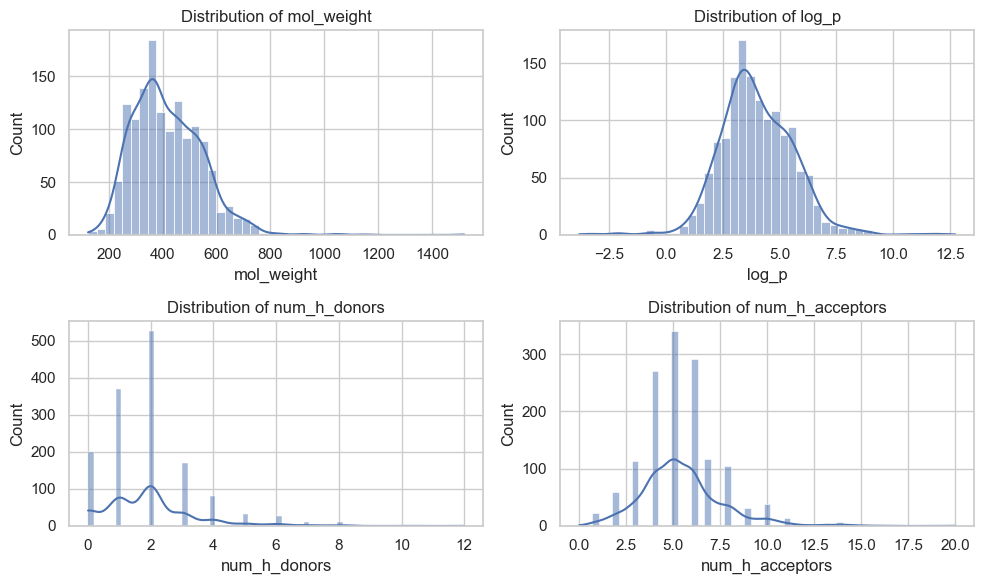

In [172]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
for i, col in enumerate(['mol_weight', 'log_p', 'num_h_donors', 'num_h_acceptors'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## Summary statistic for PaDEL descriptors

In [173]:
df_padel.describe()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
count,1425.0,1425.000000,1425.000000,1425.000000,1425.0,1425.0,1425.000000,1425.0,1425.0,1425.0,...,1425.0,1425.0,1425.0,1425.0,1425.0,1425.0,1425.0,1425.0,1425.0,1425.0
mean,1.0,0.993684,0.753684,0.194386,0.0,0.0,0.004912,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.079248,0.431016,0.395866,0.0,0.0,0.069940,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,1.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Visualize the distribution of the first few descriptors

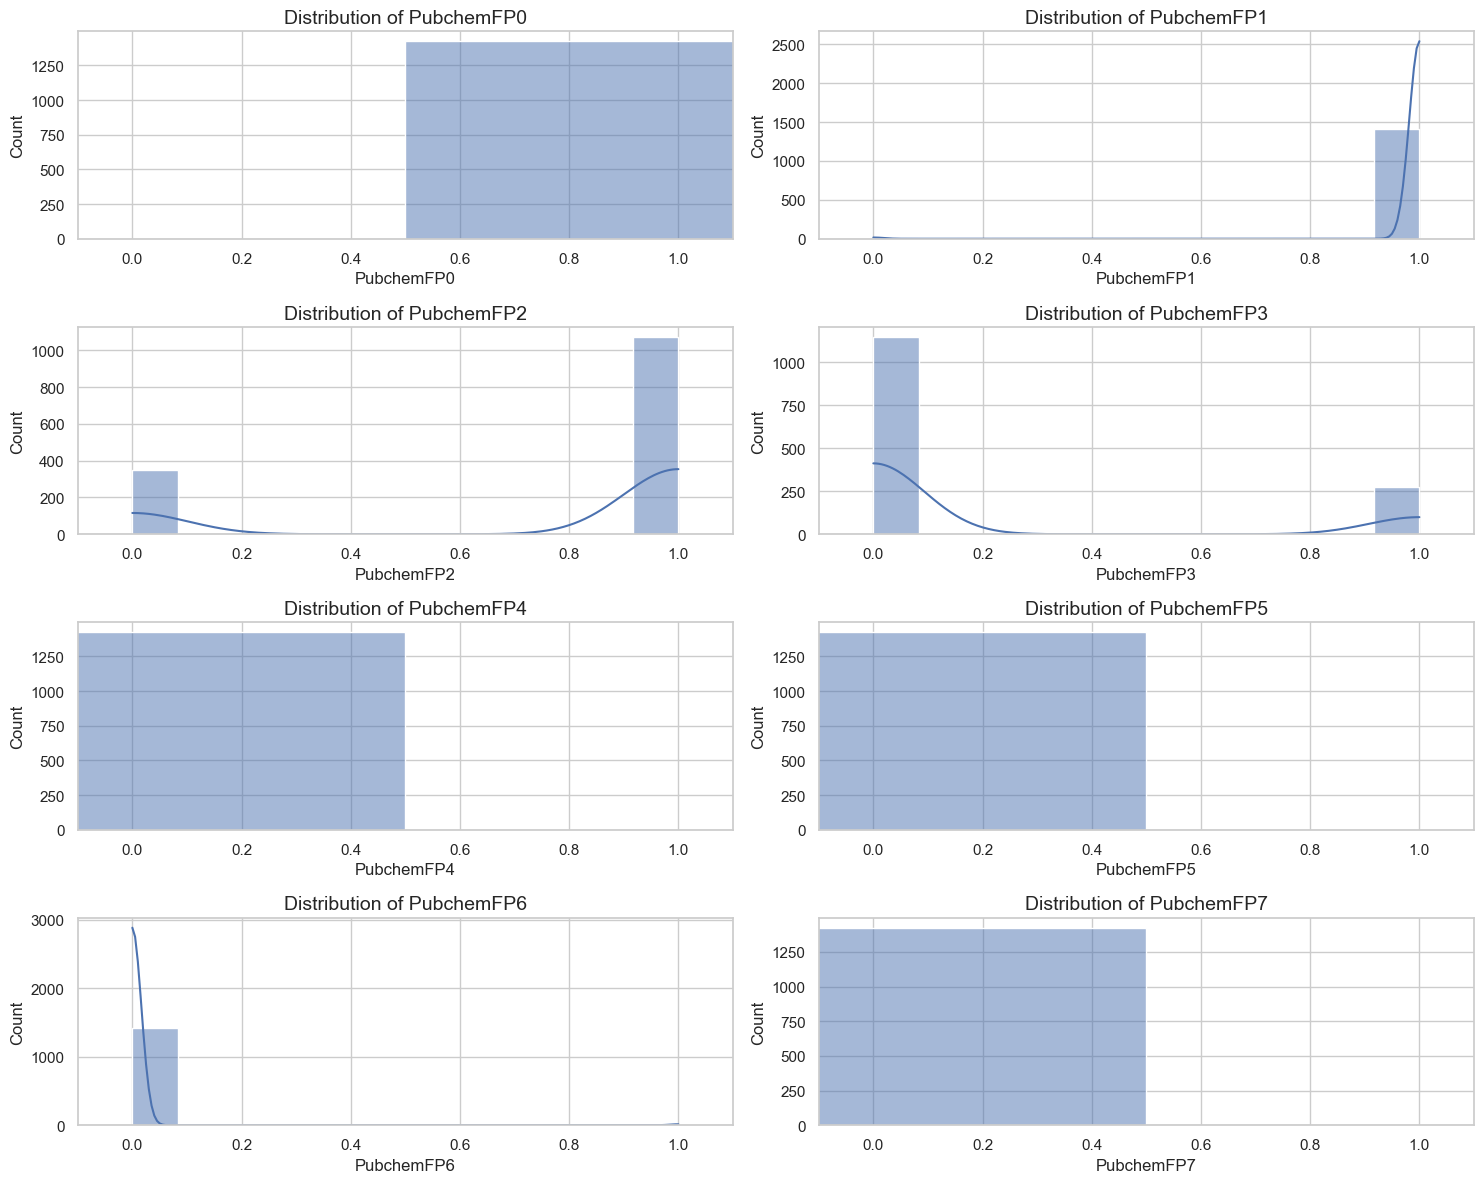

In [174]:
columns_to_plot = df_padel.columns[1:9]
plt.figure(figsize=(15, 12))

# Loop through the columns and create subplots
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_padel[column], kde=True)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xlim(-0.1, 1.1)  # Assuming fingerprint values are binary (0 or 1)

plt.tight_layout()
plt.show()

## Prepare Model input and target

Use the lipinski descriptors and molecule descriptors as the Input X
Use the pIC50 as the target Y

merge the dataframe

In [178]:
merged_df = pd.merge(df, df_padel, on='molecule_chembl_id')

In [179]:
X = merged_df.drop(columns=['pIC50', 'molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_level'])
Y = merged_df['pIC50']

# Display the shapes of X and Y to verify
print(X.shape)
print(Y.shape)

(2985, 885)
(2985,)


Download the X and Y data for model building

In [180]:
X.to_csv('X.csv')
Y.to_csv('Y.csv')